# End-to-End Multi-Object Localization and Path planning algorithm (Grid Based)

- **Project:** Detects colored objects, classifies them, and uses A* to find the most optimal path to collect and drop all objects one by one. This is all done using one Image input!!!
- **Tech Stack:** OpenCV for vision, A* for path planning, and grid-based simulation.  
- **Relevance:** Unmanned Autonomous Robots.


In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np




- `get_limits(color_name)`: Returns HSV lower and upper bounds for detecting red, yellow, and blue.  
- `detect(image_path)`: Loads an image, converts it to HSV, detects colored objects, and returns their centroids.  
- `load_and_convert_image(image_path)`: Loads an image and converts it to grayscale.  
- `display_image(image, title)`: Displays a color image using Matplotlib.  
- `display_gray_image(gray_image, title)`: Displays a grayscale image using Matplotlib.

In [2]:

def get_limits(color_name):
    if color_name == 'Red':
        lowerLimit1 = np.array([0, 100, 100], dtype=np.uint8)
        upperLimit1 = np.array([10, 255, 255], dtype=np.uint8)
        lowerLimit2 = np.array([170, 100, 100], dtype=np.uint8)
        upperLimit2 = np.array([180, 255, 255], dtype=np.uint8)
        return (lowerLimit1, upperLimit1), (lowerLimit2, upperLimit2)
    elif color_name == 'Yellow':
        lowerLimit = np.array([20, 100, 100], dtype=np.uint8)
        upperLimit = np.array([40, 255, 255], dtype=np.uint8)
        return (lowerLimit, upperLimit),
    elif color_name == 'Blue':
        lowerLimit = np.array([100, 100, 100], dtype=np.uint8)
        upperLimit = np.array([140, 255, 255], dtype=np.uint8)
        return (lowerLimit, upperLimit),
    return None

def detect(image_path):
    colors_to_find = [
        ('Yellow', (0, 255, 255)),
        ('Red', (0, 0, 255)),
        ('Blue', (255, 0, 0))
    ]

    print(f"Loading image from path: {image_path}")
    image = cv2.imread(image_path)

    if image is None:
        print("Error: Image not loaded. Check the file path.")
        return None

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    print("Converted image to HSV color space.")
    object_centroids={'Red':[], 'Blue':[]}
    for color_name, box_color in colors_to_find:
        print(f"Processing color: {color_name}")
        boundaries = get_limits(color_name)
        print(f"Color boundaries for {color_name}: {boundaries}")

        mask = None

        for lower, upper in boundaries:
            current_mask = cv2.inRange(hsv, lower, upper)
            print(f"Applied mask for range: Lower={lower}, Upper={upper}")
            mask = current_mask if mask is None else cv2.bitwise_or(mask, current_mask)

        print(f"Generated combined mask for {color_name}.")

        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        print(f"Applied morphological operations for {color_name}.")

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        print(f"Contours found for {color_name}: {len(contours)}")

        for contour in contours:
            area = cv2.contourArea(contour)
            print(f"Contour area: {area}")

            if area > 50:
                x, y, w, h = cv2.boundingRect(contour)
                print(f"Drawing bounding box for {color_name}: x={x}, y={y}, w={w}, h={h}")
                cv2.rectangle(image, (x, y), (x + w, y + h), box_color, 2)
                object_centroids[color_name].append(((x+x+w)/2, (y+y+h)/2))
                cv2.putText(image, color_name, (x, y - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, box_color, 2)
            else:
                print(f"Skipping contour with small area: {area}")

    print("Image processing complete.")
    return image, object_centroids

def load_and_convert_image(image_path):
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image, gray_image

def display_image(image, title):
    plt.figure(figsize=(8, 8))
    plt.title(title)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

def display_gray_image(gray_image, title):
    plt.figure(figsize=(8, 8))
    plt.title(title)
    plt.imshow(gray_image, cmap='gray')
    plt.axis('off')
    plt.show()



Loading image from path: /content/perspective-grid-floor-tile-detailed-lines-white-background_51530-13957.jpg
Converted image to HSV color space.
Processing color: Yellow
Color boundaries for Yellow: ((array([ 20, 100, 100], dtype=uint8), array([ 40, 255, 255], dtype=uint8)),)
Applied mask for range: Lower=[ 20 100 100], Upper=[ 40 255 255]
Generated combined mask for Yellow.
Applied morphological operations for Yellow.
Contours found for Yellow: 0
Processing color: Red
Color boundaries for Red: ((array([  0, 100, 100], dtype=uint8), array([ 10, 255, 255], dtype=uint8)), (array([170, 100, 100], dtype=uint8), array([180, 255, 255], dtype=uint8)))
Applied mask for range: Lower=[  0 100 100], Upper=[ 10 255 255]
Applied mask for range: Lower=[170 100 100], Upper=[180 255 255]
Generated combined mask for Red.
Applied morphological operations for Red.
Contours found for Red: 1
Contour area: 1360.0
Drawing bounding box for Red: x=575, y=351, w=39, h=49
Processing color: Blue
Color boundaries

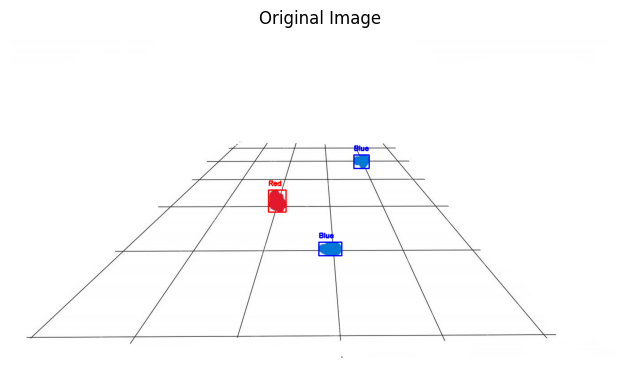

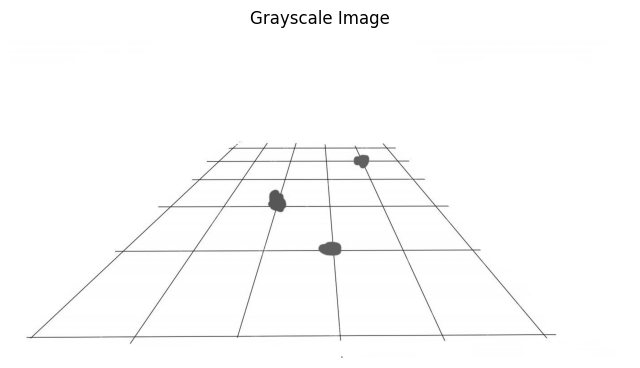

In [4]:

image_path = '/content/image.jpg'
image, gray_image = load_and_convert_image(image_path)

#Color detection
image, object_centroids= detect(image_path)


print("Detected Colors and Coords: ",object_centroids)

display_image(image, 'Original Image')
display_gray_image(gray_image, 'Grayscale Image')

# Edge(Grid) Detection

- The `detect_edges` function applies Canny edge detection to a grayscale image.  
- It highlights significant edges based on intensity gradients using two threshold values.   
- The processed edge map is displayed using `display_gray_image` for better visualization.  

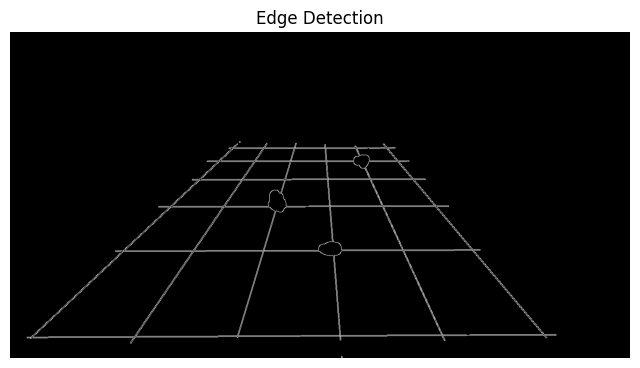

In [5]:
def detect_edges(gray_image, threshold1=100, threshold2=110):
    #blurred = cv2.GaussianBlur(gray_image, (5, 5), 0)
    edges = cv2.Canny(gray_image, threshold1, threshold2, apertureSize=3)
    return edges

edges = detect_edges(gray_image)
display_gray_image(edges, 'Edge Detection')

# Detect Lines

- The `detect_lines` function utilizes the probabilistic Hough transform to detect straight lines in an edge-detected image.  
- It represents lines parametrically and filters them based on a threshold, minimum length, and maximum gap.  

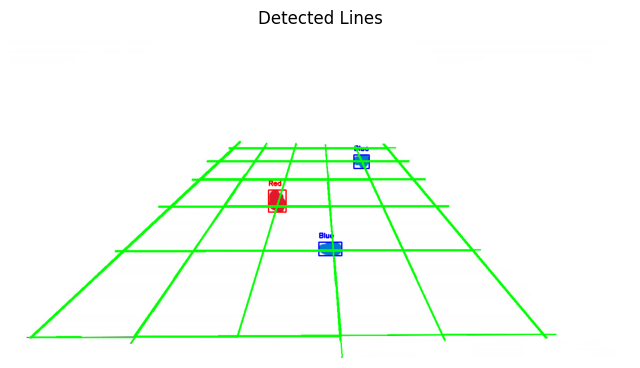

In [8]:
def detect_lines(edges, threshold=80, min_line_length=70, max_line_gap=100):
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=threshold, minLineLength=min_line_length, maxLineGap=max_line_gap)
    return lines

lines = detect_lines(edges)
image_with_lines = np.copy(image)

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)

    display_image(image_with_lines, 'Detected Lines')


# Refine

The above picture(process) is actually a lot of lines stacked together at each point.

We need to have only 6 horizontal and 6 vertical lines.

- The `merge_hor_lines` function detects and merges nearly horizontal lines based on a vertical distance threshold, ensuring alignment and continuity.  
- `merge_slanted_lines` identifies and merges lines with similar slopes and proximity, using slope-intercept calculations to maintain structural consistency.  
- Both merging functions refine line detection by reducing redundant or fragmented segments, improving clarity in structured environments.  
- The `limit_merged_lines` function selects a subset of merged lines, ensuring a maximum count while maintaining even distribution.  

In [9]:
def merge_hor_lines(lines, threshold):
    merged_lines = []

    for line in lines:
        x1, y1, x2, y2 = line[0]
        merged = False

        # Check existing merged lines to merge current line if possible
        for merged_line in merged_lines:
            mx1, my1, mx2, my2 = merged_line[0]

            # Condition for merging horizontal lines
            if abs(y1 - my1) < threshold and abs(y2 - my2) < threshold:
                merged_x1 = min(x1, mx1)
                merged_x2 = max(x2, mx2)
                merged_y1 = (y1 + my1) // 2  # Average for smoother alignment
                merged_y2 = (y2 + my2) // 2
                merged_line[0] = [merged_x1, merged_y1, merged_x2, merged_y2]
                merged = True
                break

        if not merged:
            merged_lines.append([[x1, y1, x2, y2]])

    return merged_lines

def merge_slanted_lines(lines, threshold):
    merged_lines = []

    for line in lines:
        x1, y1, x2, y2 = line[0]
        slope = (y2 - y1) / (x2 - x1 + 1e-6)  # Avoid division by zero
        intercept = y1 - slope * x1  # Calculate y-intercept for the line

        merged = False

        for merged_line in merged_lines:
            mx1, my1, mx2, my2 = merged_line[0]
            merged_slope = (my2 - my1) / (mx2 - mx1 + 1e-6)
            merged_intercept = my1 - merged_slope * mx1

            # Merge if slopes are similar and lines are close
            if abs(slope - merged_slope) < 0.2 or abs(x1 - mx1) < threshold:
                merged_x1 = min(x1, mx1)
                merged_x2 = max(x2, mx2)

                # Recalculate new y-coordinates based on slope for merged line
                merged_y1 = int(merged_slope * merged_x1 + merged_intercept)
                merged_y2 = int(merged_slope * merged_x2 + merged_intercept)

                merged_line[0] = [merged_x1, merged_y1, merged_x2, merged_y2]
                merged = True
                break

        if not merged:
            merged_lines.append([[x1, y1, x2, y2]])

    return merged_lines

def limit_merged_lines(merged_lines, max_lines=6):
    if len(merged_lines) <= max_lines:
        return merged_lines

    # Ensure first and last lines are included
    limited_lines = [merged_lines[0], merged_lines[-1]]

    # Calculate step size to distribute remaining lines evenly
    step = (len(merged_lines) - 1) / (max_lines - 1)

    # Select evenly spaced indices, excluding first and last which are already added
    for i in range(1, max_lines - 1):
        idx = round(i * step)
        if idx not in [0, len(merged_lines) - 1]:  # Avoid duplicates
            limited_lines.append(merged_lines[idx])

    return sorted(limited_lines, key=lambda x: merged_lines.index(x))


# Refine

- **Sorting Optimization:** Uses an *insertion sort* to order vertical and horizontal lines based on their starting positions before merging.  
- **Line Merging:** Merges close horizontal and slanted vertical lines using `merge_hor_lines` and `merge_slanted_lines` with predefined thresholds.   

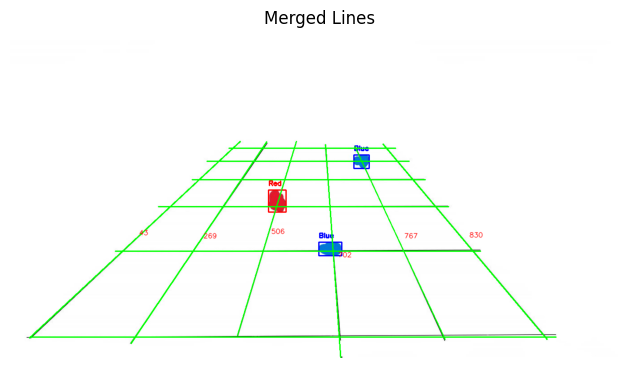

In [10]:
import numpy as np
import cv2

def merge_nearest_lines(lines, image, threshold=25):
    horizontal_lines = []
    vertical_lines = []
    vertical_lines_start = []
    horizontal_lines_start = []

    for line in lines:
        x1, y1, x2, y2 = line[0]
        if abs(y1 - y2) < 50:  # Horizontal line
            horizontal_lines.append(line)
            horizontal_lines_start.append(y1)
        elif (abs(y1 - y2) / abs(x1 - x2)) > 3 or (abs(y1 - y2) / abs(x1 - x2)) < 57:  # Vertical line
            vertical_lines.append(line)
            vertical_lines_start.append(x1)

    def insertion_sort(arr, data):
        for i in range(1, len(arr)):
            key = arr[i]
            key2 = data[i]
            j = i - 1
            while j >= 0 and arr[j] > key:
                arr[j + 1] = arr[j]
                data[j + 1] = data[j]
                j -= 1
            arr[j + 1] = key
            data[j + 1] = key2
        return data

    vertical_lines = insertion_sort(vertical_lines_start, vertical_lines)
    horizontal_lines = insertion_sort(horizontal_lines_start, horizontal_lines)

    merged_horizontal_lines = merge_hor_lines(horizontal_lines, 10)
    merged_vertical_lines = merge_slanted_lines(vertical_lines, 50)

    image_with_merged_lines = np.copy(image)

    for line in merged_horizontal_lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image_with_merged_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)

    for line in merged_vertical_lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image_with_merged_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)


    return image_with_merged_lines, merged_horizontal_lines, merged_vertical_lines

image_with_merged_lines, merged_horizontal_lines, merged_vertical_lines = merge_nearest_lines(lines, image)
display_image(image_with_merged_lines, 'Merged Lines')


# Intersection

- **Intersection Calculation:** Determines intersection points of horizontal and vertical lines, handling vertical lines separately to avoid division errors.  
- **Indexing Grid Points:** Iterates through all line intersections, assigning an index to each square corner in the grid.  


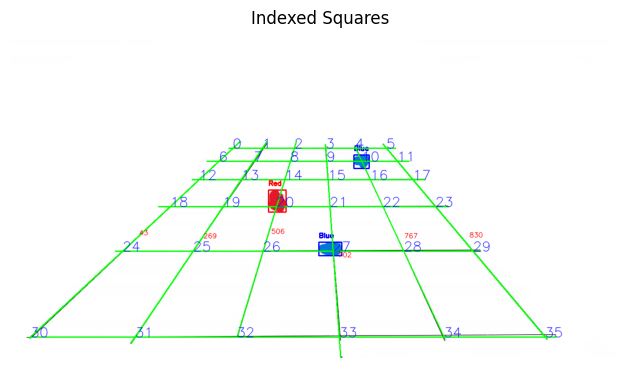

In [12]:
def find_intersection(line1, line2):
    x1, y1, x2, y2 = line1
    x3, y3,x4, y4 = line2

    def slope(x1, y1, x2, y2):
        if x2 - x1 == 0:  # Vertical line
            return float('inf')
        return (y2 - y1) / (x2 - x1)

    m1 = slope(x1, y1, x2, y2)
    m2 = slope(x3, y3, x4, y4)

    if m1 == m2:
        return None

    if m1 == float('inf'):  # Line 1 is vertical
        x = x1
        y = m2 * (x - x3) + y3
    elif m2 == float('inf'):  # Line 2 is vertical
        x = x3
        y = m1 * (x - x1) + y1
    else:
        x = (y3 - y1 + m1 * x1 - m2 * x3) / (m1 - m2)
        y = m1 * (x - x1) + y1

    return (x, y)

def index_squares(image, horizontal_lines, vertical_lines):
    horizontal_lines_excluding_top = horizontal_lines
    new_img = np.copy(image)
    index = 0
    index_ords = []
    for i in range(0,(len(horizontal_lines))):
      for j in range(0, len(vertical_lines)):
        x,y = find_intersection(horizontal_lines[i][0], vertical_lines[j][0])
        index_ords.append((x,y))
        cv2.putText(new_img, str(index), (int(x),int(y)),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1, cv2.LINE_AA)
        index+=1
    return new_img, index_ords

image_with_indexed_squares, index_ords = index_squares(image_with_merged_lines, merged_horizontal_lines, merged_vertical_lines)
display_image(image_with_indexed_squares, 'Indexed Squares')

# Localizing Objects

To programatically localize objects we assign them an grid intersection and will later go to that intersection point.

For that, we need to know closest intersection point for each object.

The `find_nearest_pairs` function assigns each object (from `object_coords`) to the closest available intersection (from `intersections`) using Euclidean distance. The algorithm ensures that each intersection is used only once, preventing multiple objects from being assigned to the same point.  

In [14]:
import numpy as np

def find_nearest_pairs(intersections, object_coords):
    nearest_pairs = {key: [] for key in object_coords}
    used = set()

    intersections_array = np.array(intersections)

    for category, coords_list in object_coords.items():
        for x1, y1 in coords_list:  # Iterate over coordinates in each category
            distances = np.sqrt((intersections_array[:, 0] - x1) ** 2 + (intersections_array[:, 1] - y1) ** 2)
            nearest_idx = np.argmin(distances)


            while nearest_idx in used:
                distances[nearest_idx] = np.inf  # Mark the current nearest as invalid
                nearest_idx = np.argmin(distances)

            nearest_pairs[category].append(nearest_idx)
            used.add(nearest_idx)  # Mark this index as used

    return nearest_pairs


In [15]:
object_loc = find_nearest_pairs(index_ords, object_centroids)

In [20]:
object_loc

{'Red': [20], 'Blue': [27, 10]}

### Let's Solve the Puzzle!

So far, we’ve figured out where objects are on the grid and found the closest intersection points. Now, we need to move efficiently between these points while picking up and dropping off objects.  

To do this, we’ll use the **A* (A-Star) pathfinding algorithm**, which helps find the best route on a **6×6 grid**.  

The algorithm uses a heuristic called the **Manhattan distance** to estimate how far a point is from the goal.
### **The Plan **  
drop_offs = {'Red': 17, 'Blue': 12}

Given the above locations, take each object to the appropraite destination (The most optimal way).

We keep track of two important numbers:  
- **`g_score`** → How much it has cost us to move from the start to the current spot.  
- **`f_score`** → Our best guess of the total cost from start to goal (`g_score + estimated distance left`).  

### **Steps to Find the Best Path:**  

1. **Start the Search:**  
   - Put the starting position into a list of places to check (we call this `open_list`).  
   - Set `g_score[start] = 0` (since we haven’t moved yet).  
   - Estimate the total cost to the goal and store it in `f_score[start]`.  

2. **Look for the Best Route:**  
   - Keep going while we still have positions left to explore:  
     
     a. **Pick the Best Option:**  
        - Choose the spot with the lowest `f_score` (most promising path).  

     b. **Check If We Made It:**  
        - If we reached the goal, stop! We can now rebuild the path we took.  

     c. **Check Neighboring Positions:**  
        - Look at all valid moves (left, right, up, down).  
        - Calculate the movement cost to get there.  
        - If this new path is **cheaper** than what we had recorded:  
          - Update the cost (`g_score`).  
          - Update the estimated total cost (`f_score`).  
          - Remember where we came from (this helps us reconstruct the path later).  
          - Add this position to the `open_list` if it's not there yet.  

3. **Final Check:**  
   - If we run out of positions and never reach the goal, there’s no valid path. Return an empty path.  

In [17]:
import heapq

def manhattan_distance(start, goal, grid_size=6):
    start_x, start_y = start // grid_size, start % grid_size
    goal_x, goal_y = goal // grid_size, goal % grid_size
    return abs(start_x - goal_x) + abs(start_y - goal_y)

def a_star(start, goal, grid_size=6):
    open_set = []
    heapq.heappush(open_set, (0, start))

    came_from = {}
    g_score = {i: float('inf') for i in range(grid_size * grid_size)}
    g_score[start] = 0

    f_score = {i: float('inf') for i in range(grid_size * grid_size)}
    f_score[start] = manhattan_distance(start, goal)

    while open_set:
        # Get the node with the lowest f_score
        current = heapq.heappop(open_set)[1]

        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            return path[::-1]

        # Explore neighbors (up, down, left, right)
        neighbors = []
        if current % grid_size != 0:  # Left
            neighbors.append(current - 1)
        if current % grid_size != grid_size - 1:  # Right
            neighbors.append(current + 1)
        if current >= grid_size:  # Up
            neighbors.append(current - grid_size)
        if current < (grid_size - 1) * grid_size:  # Down
            neighbors.append(current + grid_size)

        for neighbor in neighbors:
            tentative_g_score = g_score[current] + 1  # Each step costs 1

            if tentative_g_score < g_score[neighbor]:
                # Update the path and scores
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = g_score[neighbor] + manhattan_distance(neighbor, goal)
                heapq.heappush(open_set, (f_score[neighbor], neighbor))

    return []  # Return an empty path if no path exists

def find_full_route(start, objects, drop_offs):
    route = []
    current_position = start

    # Combine all tasks (pickup → drop-off pairs)
    tasks = []
    for obj, positions in objects.items():
        drop_off = drop_offs[obj]
        for position in positions:
            tasks.append((position, drop_off))

    while tasks:
        # Find the closest task based on Manhattan Distance
        tasks.sort(key=lambda task: manhattan_distance(current_position, task[0]))
        closest_task = tasks.pop(0)

        # Pickup path
        pickup_path = a_star(current_position, closest_task[0])
        route.extend(pickup_path[:-1])  # Avoid duplicate positions

        # Drop-off path
        drop_off_path = a_star(closest_task[0], closest_task[1])
        route.extend(drop_off_path[:-1])  # Avoid duplicate positions

        # Update current position
        current_position = closest_task[1]

    # Add the final position
    route.append(current_position)
    return route

# Example usage
start = 35

drop_offs = {'Red': 17, 'Blue': 12}

route = find_full_route(start, object_loc, drop_offs)
print("Route:", route)


Route: [35, 29, 28, 27, 21, 15, 14, 13, 12, 13, 14, 20, 14, 15, 16, 17, 11, 10, 9, 8, 7, 6, 12]


# Now all we need to do is Follow the route!!!


By Adonay Gebremedhin